In [1]:
import requests
from pathlib import Path
from shapely.geometry import shape
import json
from isce2_topsapp.delivery_prep import prepare_for_delivery
from isce2_topsapp.water_mask import get_water_mask_dataframe, get_water_mask_raster
from isce2_topsapp.delivery_prep import get_dataset_schema
import rasterio
import matplotlib.pyplot as plt
import jsonschema

# Prepare for Delivery

In [2]:
url = 'https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4.nc'
nc_path = Path(url.split('/')[-1])

resp = requests.get(url)
with open(nc_path, 'wb') as file:
    file.write(resp.content)

In [3]:
sample_data = json.load(open('sample_loc_metadata.json'))
sample_data['ref_orbit'] = Path(sample_data['ref_orbit'])
sample_data['sec_orbit'] = Path(sample_data['sec_orbit'])
sample_data['full_res_dem_path'] = Path(sample_data['full_res_dem_path'])
sample_data['low_res_dem_path'] = Path(sample_data['low_res_dem_path'])

sample_data['intersection_geo'] = shape(sample_data['intersection_geo'])

In [4]:
final_prod_directory = prepare_for_delivery(nc_path, sample_data)
paths = list(final_prod_directory.glob('*'))
paths

[PosixPath('S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4/.DS_Store'),
 PosixPath('S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4/S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4.json'),
 PosixPath('S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4/S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4.png'),
 PosixPath('S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4/S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4.nc')]

# Validate JSON

In [5]:
schema = get_dataset_schema()
metadata = json.load(open('S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4/S1-GUNW-A-R-064-tops-20210723_20210711-015001-35393N_33512N-PP-6267-v2_0_4.json'))

assert(jsonschema.validate(instance=metadata, schema=schema) is None)

# Water Mask Tests

In [6]:
nc_path_new = list(filter(lambda x: '.nc' in x.name, paths))[0]

In [7]:
with rasterio.open(f'netcdf:{str(nc_path_new)}:/science/grids/data/connectedComponents') as ds:
    p = ds.profile

In [8]:
%%time

X = get_water_mask_raster(p)

CPU times: user 8.51 s, sys: 3.83 s, total: 12.3 s
Wall time: 1min 48s


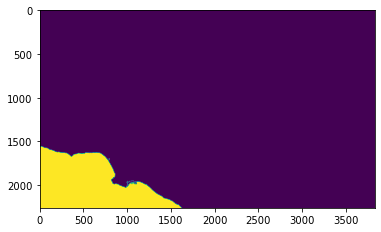

In [9]:
plt.imshow(X)

Get a profile over the dateline

In [10]:
t = p['transform']
t2 = t.translation(xoff=-61, yoff=31) * t
t2

Affine(0.000833333333333333, 0.0, -180.10791666666665,
       0.0, -0.0008333333333333338, 66.39375)

In [11]:
%%time

p2 = p.copy()
p2['transform'] = t2
X2 = get_water_mask_raster(p2)

CPU times: user 12.6 s, sys: 8.13 s, total: 20.8 s
Wall time: 2min 55s


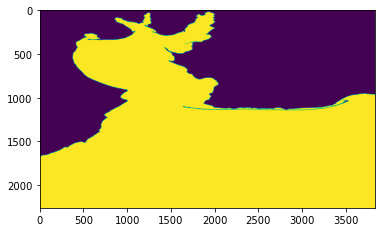

In [12]:
plt.imshow(X2)

## Read Vectorfile

Again over the dateline in the +180 degree region.

In [13]:
bounds = [175, 64, 185, 66]

df = get_water_mask_dataframe(bounds)

<AxesSubplot:>

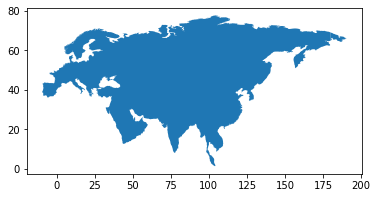

In [14]:
df.plot()